# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"

This notebook reports the results of preliminary runs for the scenarios defined in the table [here](https://docs.google.com/document/d/1ssc5ilxEhEYYjFDCo5cIAgP7zSRcO4uVUXjxbyfR88Q/edit?tab=t.0).

**Scenarios Analyzed:**
- *Scenario 1: [Brief Description]*
- *Scenario 2: [Brief Description]*
- *Scenario 10: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [1]:
!pip install plotly -qq

In [164]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings("ignore")

### 1.2. Load Solved Network(s)

In [3]:
# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / "scenario_01"

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    file_name = f"elec_s_100_ec_lcopt_3H_3H_{year}_0.071_AB_10export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        key = f"scenario_01_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2030


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2035


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2040

 Uploaded networks:
['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040']


In [4]:
region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

In [5]:
tech_colors = {
    "onwind": "#235ebc",
    "onshore wind": "#235ebc",
    "offwind": "#6895dd",
    "offshore wind": "#6895dd",
    "offwind-ac": "#6895dd",
    "offshore wind (AC)": "#6895dd",
    "offshore wind ac": "#6895dd",
    "offwind-dc": "#74c6f2",
    "offshore wind (DC)": "#74c6f2",
    "offshore wind dc": "#74c6f2",
    "offwind-float": "#b5e2fa",
    "offshore wind (Float)": "#b5e2fa",
    "offshore wind float": "#b5e2fa",
    "hydro": "#298c81",
    "hydro reservoir": "#298c81",
    "ror": "#3dbfb0",
    "run of river": "#3dbfb0",
    "hydroelectricity": "#298c81",
    "PHS": "#51dbcc",
    "hydro+PHS": "#08ad97",
    "csp": "#f7a401",
    "solar": "#f9d002",
    "solar PV": "#f9d002",
    "solar-hsat": "#fdb915",
    "solar thermal": "#ffbf2b",
    "residential rural solar thermal": "#f1c069",
    "services rural solar thermal": "#eabf61",
    "residential urban decentral solar thermal": "#e5bc5a",
    "services urban decentral solar thermal": "#dfb953",
    "urban central solar thermal": "#d7b24c",
    "solar rooftop": "#ffea80",
    "OCGT": "#e0986c",
    "OCGT marginal": "#e0986c",
    "OCGT-heat": "#e0986c",
    "gas boiler": "#db6a25",
    "gas boilers": "#db6a25",
    "gas boiler marginal": "#db6a25",
    "residential rural gas boiler": "#d4722e",
    "residential urban decentral gas boiler": "#cb7a36",
    "services rural gas boiler": "#c4813f",
    "services urban decentral gas boiler": "#ba8947",
    "urban central gas boiler": "#b0904f",
    "gas": "#e05b09",
    "fossil gas": "#e05b09",
    "natural gas": "#e05b09",
    "biogas to gas": "#e36311",
    "biogas to gas CC": "#e51245",
    "CCGT": "#a85522",
    "CCGT marginal": "#a85522",
    "allam": "#B98F76",
    "gas for industry co2 to atmosphere": "#692e0a",
    "gas for industry co2 to stored": "#8a3400",
    "gas for industry": "#853403",
    "gas for industry CC": "#692e0a",
    "gas pipeline": "#ebbca0",
    "gas pipeline new": "#a87c62",
    "oil": "#262626",
    "oil primary": "#d2d2d2",
    "oil refining": "#e6e6e6",
    "imported oil": "#a3a3a3",
    "oil boiler": "#adadad",
    "residential rural oil boiler": "#a9a9a9",
    "services rural oil boiler": "#a5a5a5",
    "residential urban decentral oil boiler": "#a1a1a1",
    "urban central oil boiler": "#9d9d9d",
    "services urban decentral oil boiler": "#999999",
    "agriculture machinery oil": "#949494",
    "shipping oil": "#808080",
    "land transport oil": "#afafaf",
    "Nuclear": "#ff8c00",
    "Nuclear marginal": "#ff8c00",
    "nuclear": "#ff8c00",
    "uranium": "#ff8c00",
    "Coal": "#545454",
    "coal": "#545454",
    "Coal marginal": "#545454",
    "coal for industry": "#343434",
    "solid": "#545454",
    "Lignite": "#826837",
    "lignite": "#826837",
    "Lignite marginal": "#826837",
    "biogas": "#e3d37d",
    "biomass": "#baa741",
    "solid biomass": "#baa741",
    "municipal solid waste": "#91ba41",
    "solid biomass import": "#d5ca8d",
    "solid biomass transport": "#baa741",
    "solid biomass for industry": "#7a6d26",
    "solid biomass for industry CC": "#47411c",
    "solid biomass for industry co2 from atmosphere": "#736412",
    "solid biomass for industry co2 to stored": "#47411c",
    "urban central solid biomass CHP": "#9d9042",
    "urban central solid biomass CHP CC": "#6c5d28",
    "biomass boiler": "#8A9A5B",
    "residential rural biomass boiler": "#a1a066",
    "residential urban decentral biomass boiler": "#b0b87b",
    "services rural biomass boiler": "#c6cf98",
    "services urban decentral biomass boiler": "#dde5b5",
    "biomass to liquid": "#32CD32",
    "unsustainable solid biomass": "#998622",
    "unsustainable bioliquids": "#32CD32",
    "electrobiofuels": "red",
    "BioSNG": "#123456",
    "BioSNG CC": "#45233b",
    "solid biomass to hydrogen": "#654321",
    "lines": "#6c9459",
    "transmission lines": "#6c9459",
    "electricity distribution grid": "#97ad8c",
    "low voltage": "#97ad8c",
    "Electric load": "#110d63",
    "electric demand": "#110d63",
    "electricity": "#110d63",
    "industry electricity": "#2d2a66",
    "industry new electricity": "#2d2a66",
    "agriculture electricity": "#494778",
    "battery": "#ace37f",
    "battery storage": "#ace37f",
    "battery charger": "#88a75b",
    "battery discharger": "#5d4e29",
    "home battery": "#80c944",
    "home battery storage": "#80c944",
    "home battery charger": "#5e8032",
    "home battery discharger": "#3c5221",
    "BEV charger": "#baf238",
    "V2G": "#e5ffa8",
    "land transport EV": "#baf238",
    "land transport demand": "#38baf2",
    "EV battery": "#baf238",
    "water tanks": "#e69487",
    "residential rural water tanks": "#f7b7a3",
    "services rural water tanks": "#f3afa3",
    "residential urban decentral water tanks": "#f2b2a3",
    "services urban decentral water tanks": "#f1b4a4",
    "urban central water tanks": "#e9977d",
    "hot water storage": "#e69487",
    "hot water charging": "#e8998b",
    "urban central water tanks charger": "#b57a67",
    "residential rural water tanks charger": "#b4887c",
    "residential urban decentral water tanks charger": "#b39995",
    "services rural water tanks charger": "#b3abb0",
    "services urban decentral water tanks charger": "#b3becc",
    "hot water discharging": "#e99c8e",
    "urban central water tanks discharger": "#b9816e",
    "residential rural water tanks discharger": "#ba9685",
    "residential urban decentral water tanks discharger": "#baac9e",
    "services rural water tanks discharger": "#bbc2b8",
    "services urban decentral water tanks discharger": "#bdd8d3",
    "water pits": "#cc826a",
    "water pits charger": "#b36a5e",
    "water pits discharger": "#b37468",
    "urban central water pits": "#d96f4c",
    "urban central water pits charger": "#a85d47",
    "urban central water pits discharger": "#b36452",
    "aquifer thermal energy storage": "#6d00fc",
    "aquifer thermal energy storage charger": "#6d00fc",
    "aquifer thermal energy storage discharger": "#6d00fc",
    "Heat load": "#cc1f1f",
    "heat": "#cc1f1f",
    "heat vent": "#aa3344",
    "heat demand": "#cc1f1f",
    "rural heat": "#ff5c5c",
    "residential rural heat": "#ff7c7c",
    "services rural heat": "#ff9c9c",
    "central heat": "#cc1f1f",
    "urban central heat": "#d15959",
    "urban central heat vent": "#a74747",
    "decentral heat": "#750606",
    "residential urban decentral heat": "#a33c3c",
    "services urban decentral heat": "#cc1f1f",
    "low-temperature heat for industry": "#8f2727",
    "process heat": "#ff0000",
    "agriculture heat": "#d9a5a5",
    "heat pumps": "#2fb537",
    "heat pump": "#2fb537",
    "air heat pump": "#36eb41",
    "residential rural ground heat pump": "#4f2144",
    "residential rural air heat pump": "#48f74f",
    "Ambient": "#98eb9d",
    "CHP": "#8a5751",
    "urban central gas CHP": "#8d5e56",
    "CHP CC": "#634643",
    "urban central gas CHP CC": "#6e4e4c",
    "CHP heat": "#8a5751",
    "CHP electric": "#8a5751",
    "district heating": "#e8beac",
    "resistive heater": "#d8f9b8",
    "residential rural resistive heater": "#bef5b5",
    "residential urban decentral resistive heater": "#b2f1a9",
    "services rural resistive heater": "#a5ed9d",
    "services urban decentral resistive heater": "#98e991",
    "urban central resistive heater": "#8cdf85",
    "retrofitting": "#8487e8",
    "building retrofitting": "#8487e8",
    "H2 for industry": "#f073da",
    "H2 for shipping": "#ebaee0",
    "H2": "#bf13a0",
    "hydrogen": "#bf13a0",
    "retrofitted H2 boiler": "#e5a0d9",
    "SMR": "#870c71",
    "SMR CC": "#4f1745",
    "H2 liquefaction": "#d647bd",
    "hydrogen storage": "#bf13a0",
    "H2 Store": "#bf13a0",
    "H2 storage": "#bf13a0",
    "land transport fuel cell": "#6b3161",
    "H2 pipeline": "#f081dc",
    "H2 pipeline retrofitted": "#ba99b5",
    "H2 Fuel Cell": "#c251ae",
    "H2 fuel cell": "#c251ae",
    "H2 turbine": "#991f83",
    "H2 Electrolysis": "#ff29d9",
    "H2 electrolysis": "#ff29d9",
    "NH3": "#46caf0",
    "ammonia": "#46caf0",
    "ammonia store": "#00ace0",
    "ammonia cracker": "#87d0e6",
    "Haber-Bosch": "#076987",
    "Sabatier": "#9850ad",
    "methanation": "#c44ce6",
    "methane": "#c44ce6",
    "Fischer-Tropsch": "#25c49a",
    "liquid": "#25c49a",
    "kerosene for aviation": "#a1ffe6",
    "naphtha for industry": "#57ebc4",
    "methanol-to-kerosene": "#C98468",
    "methanol-to-olefins/aromatics": "#FFA07A",
    "Methanol steam reforming": "#FFBF00",
    "Methanol steam reforming CC": "#A2EA8A",
    "methanolisation": "#00FFBF",
    "biomass-to-methanol": "#EAD28A",
    "biomass-to-methanol CC": "#EADBAD",
    "allam methanol": "#B98F76",
    "CCGT methanol": "#B98F76",
    "CCGT methanol CC": "#B98F76",
    "OCGT methanol": "#B98F76",
    "methanol": "#FF7B00",
    "methanol transport": "#FF7B00",
    "shipping methanol": "#468c8b",
    "industry methanol": "#468c8b",
    "CC": "#f29dae",
    "CCS": "#f29dae",
    "CO2 sequestration": "#f29dae",
    "DAC": "#ff5270",
    "co2 stored": "#f2385a",
    "co2 sequestered": "#f2682f",
    "co2": "#f29dae",
    "co2 vent": "#ffd4dc",
    "CO2 pipeline": "#f5627f",
    "process emissions CC": "#000000",
    "process emissions": "#222222",
    "process emissions to stored": "#444444",
    "process emissions to atmosphere": "#888888",
    "oil emissions": "#aaaaaa",
    "shipping oil emissions": "#555555",
    "shipping methanol emissions": "#666666",
    "land transport oil emissions": "#777777",
    "agriculture machinery oil emissions": "#333333",
    "shipping": "#03a2ff",
    "power-to-heat": "#2fb537",
    "power-to-gas": "#c44ce6",
    "power-to-H2": "#ff29d9",
    "power-to-liquid": "#25c49a",
    "gas-to-power/heat": "#ee8340",
    "waste": "#e3d37d",
    "other": "#000000",
    "geothermal": "#ba91b1",
    "geothermal heat": "#ba91b1",
    "geothermal district heat": "#d19D00",
    "geothermal organic rankine cycle": "#ffbf00",
    "AC": "#70af1d",
    "AC-AC": "#70af1d",
    "AC line": "#70af1d",
    "links": "#8a1caf",
    "HVDC links": "#8a1caf",
    "DC": "#8a1caf",
    "DC-DC": "#8a1caf",
    "DC link": "#8a1caf",
    "load": "#dd2e23",
    "waste CHP": "#e3d37d",
    "waste CHP CC": "#e3d3ff",
    "non-sequestered HVC": "#8f79b5",
    "HVC to air": "k",
    "import H2": "#db8ccd",
    "import gas": "#f7a572",
    "import NH3": "#e2ed74",
    "import oil": "#93eda2",
    "import methanol": "#87d0e6",
    'Alkaline electrolyzer large': '#1f77b4',
    'PEM electrolyzer': '#2ca02c',
    'SOEC': '#d62728',
}

nice_names = {
    # Primary Energy & Fuels
    'gas': 'Gas',
    'oil': 'Oil',
    'coal': 'Coal',
    'lignite': 'Lignite',
    'biomass': 'Biomass',
    'solid biomass': 'Solid Biomass',
    'biogas': 'Biogas',
    'co2': 'CO2',
    'h2': 'Hydrogen',
    'H2': 'Hydrogen', # Including capitalized version for robustness

    # Storage
    'battery': 'Battery Storage',
    'home battery': 'Home Battery',
    'water tanks': 'Water Tanks',

    # Solar
    'solar rooftop': 'Rooftop Solar',
    'solar thermal': 'Solar Thermal', # Added for completeness
    
    # E-Fuels
    'e-kerosene': 'E-Kerosene',

    # Decentralized Heat (by sector and location)
    'residential rural heat': 'Residential Rural Heat',
    'residential rural water tanks': 'Residential Rural Water Tanks',
    'residential rural solar thermal': 'Residential Rural Solar Thermal',
    
    'services rural heat': 'Services Rural Heat',
    'services rural water tanks': 'Services Rural Water Tanks',
    'services rural solar thermal': 'Services Rural Solar Thermal',

    'residential urban decentral heat': 'Residential Urban Decentralized Heat',
    'residential urban decentral water tanks': 'Residential Urban Decentralized Water Tanks',
    'residential urban decentral solar thermal': 'Residential Urban Decentralized Solar Thermal',

    'services urban decentral heat': 'Services Urban Decentralized Heat',
    'services urban decentral water tanks': 'Services Urban Decentralized Water Tanks',
    'services urban decentral solar thermal': 'Services Urban Decentralized Solar Thermal',

    # Centralized Heat
    'urban central heat': 'Urban Central Heat',
    'urban central water tanks': 'Urban Central Water Tanks',
    'urban central solar thermal': 'Urban Central Solar Thermal',

    # Storage & Energy Carriers
    'Li ion': 'Lithium-ion Battery',
    'NH3': 'Ammonia',
    'H2': 'Hydrogen',  # Assuming you might have H2 as well
    'grid H2': 'Grid Hydrogen',

    # Biofuels
    'bioethanol crop': 'Bioethanol Crop',
    'ethanol': 'Ethanol',

    # Steel Production
    'iron ore': 'Iron Ore',
    'DRI': 'Direct Reduced Iron (DRI)',
    'steel BF-BOF': 'Steel (BF-BOF)',
    'scrap steel': 'Scrap Steel',
    'steel EAF': 'Steel (EAF)',

    # Cement Production
    'clinker': 'Clinker',
    'cement': 'Cement',

}

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [6]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [7]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040'])

In [8]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]

demand = pd.DataFrame(columns=networks.keys(), index=dynamic_load_carriers+static_load_carriers+["total demand"])
demand_profile = pd.DataFrame(columns=networks.keys(), index=networks["Base_2023"].snapshots)
ac_load, services_load, ev_load = 0, 0, 0

for name, n in networks.items():

    # calculate static loads and its profile
    nhours = n.snapshot_weightings.objective.sum()
    static_totals = (
        n.loads.groupby("carrier")
            .sum().p_set
            .reindex(static_load_carriers)
            .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # calculate dynamic loads and profiles
    # ac_loads = n.loads.query("carrier in 'AC'").index
    # ac_profile = n.loads_t.p_set[ac_loads].sum(axis=1)
    # ac_load = ac_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6

    # 3. Services & EV
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx   = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
                if i in n.loads_t.p_set.columns]

    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile   = n.loads_t.p_set[ev_idx].sum(axis=1)   if ev_idx else 0

    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh   = (ev_profile   * n.snapshot_weightings.objective).sum() / 1e6

    # 4. Industry electricity total = static + industrial AC
    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh

    dynamic_profile = ac_profile + serv_profile + ev_profile
    demand_profile.loc[:, name] = dynamic_profile + static_totals.sum()

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity",      name] = static_totals.get("agriculture electricity",  0) * nhours / 1e6
    demand.loc["industry electricity",         name] = industry_elec_twh
    demand.loc["AC",                           name] = ac_twh
    demand.loc["services electricity",         name] = serv_twh
    demand.loc["land transport EV",            name] = ev_twh
    demand.loc["total demand",                 name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh
    )


In [9]:
demand

,Base_2023,scenario_01_2030,scenario_01_2035,scenario_01_2040
AC,1399.790281,1490.519908,1558.831601,1630.208261
services electricity,1338.936409,1386.508012,1421.519077,1457.414215
land transport EV,69.576977,318.254464,550.52874,733.479015
rail transport electricity,5.5476,5.5476,5.5476,5.5476
agriculture electricity,57.3213,57.3213,57.3213,57.3213
industry electricity,804.420936,886.717069,932.849589,981.953359
total demand,3675.593503,4144.868353,4526.597907,4865.92375


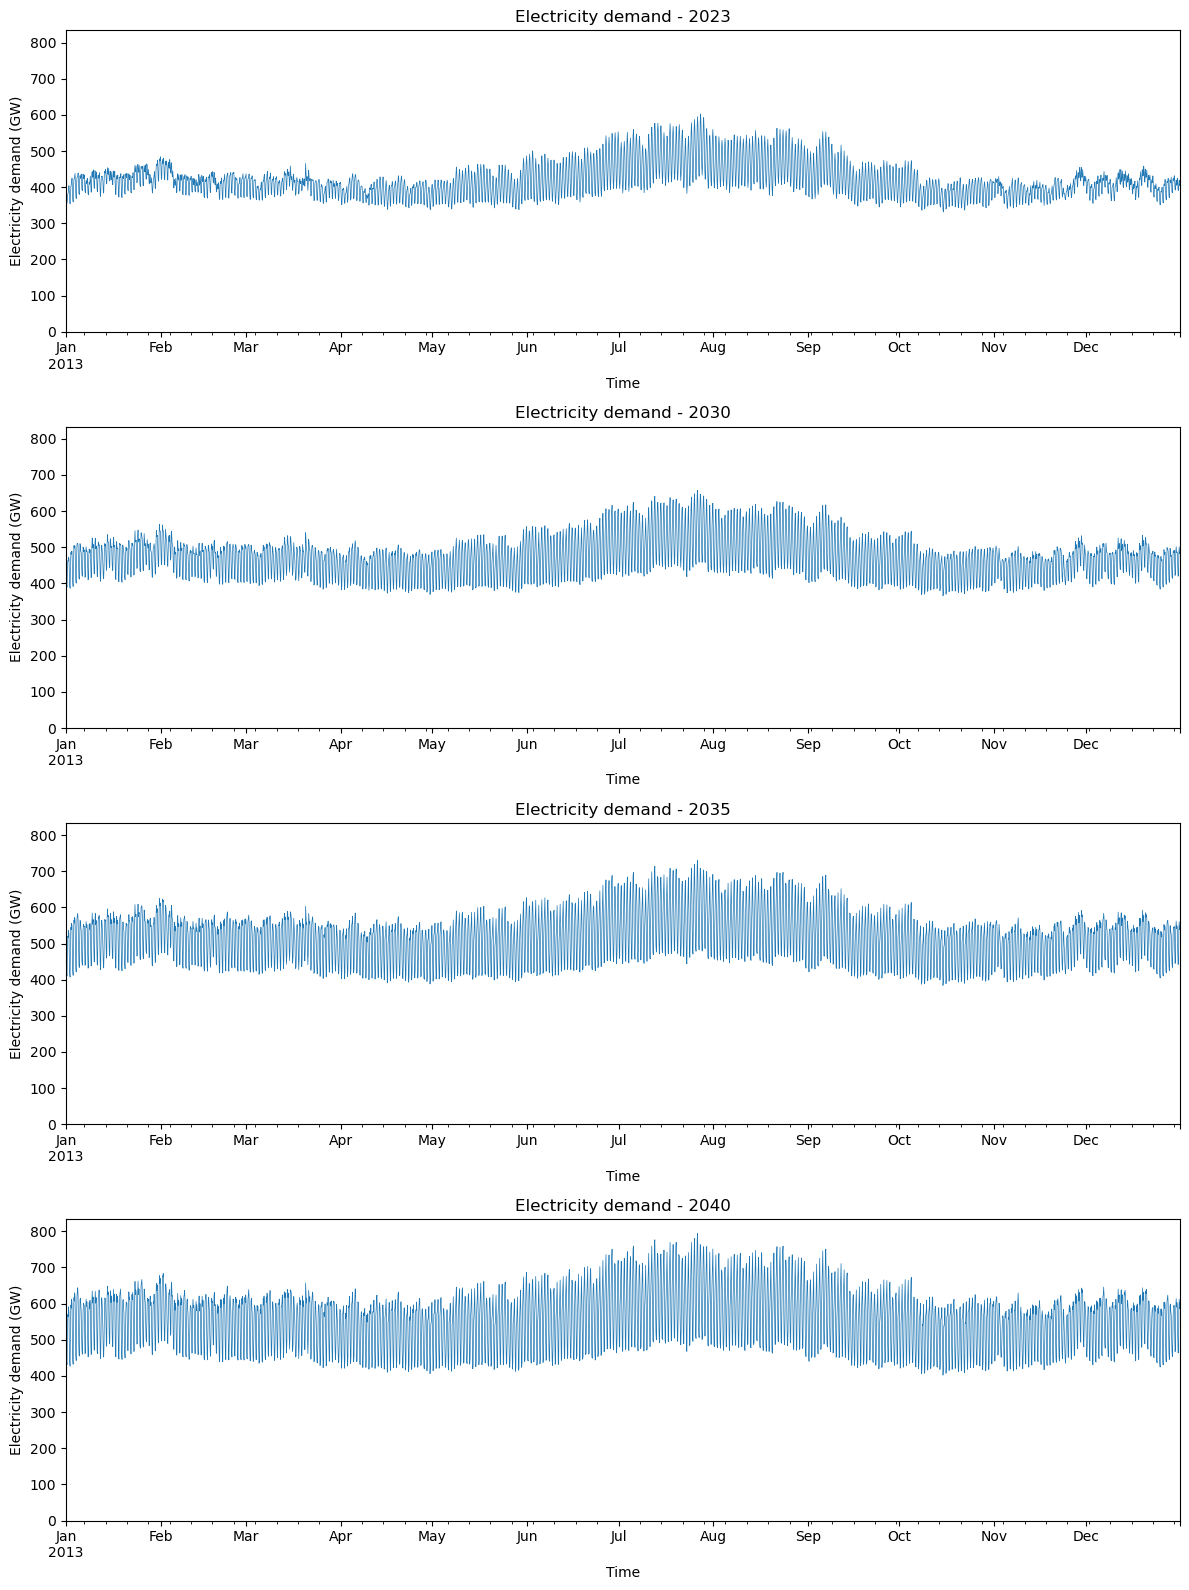

In [10]:
years = set()
for col in demand_profile.columns:
    match = re.search(r"\d{4}", col)
    if match:
        years.add(int(match.group()))

years = sorted(years)

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(12, 4 * len(years)))

y_max = (demand_profile / 1e3).max().max() * 1.05

for ax, year in zip(axes, years):
    cols = [col for col in demand_profile.columns if str(year) in col]
    if cols:
        (demand_profile[cols] / 1e3).plot(ax=ax, linewidth=0.5, legend = False)
        ax.set_title(f"Electricity demand - {year}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electricity demand (GW)")
        ax.set_ylim(0, y_max)
    else:
        ax.set_visible(False)

plt.tight_layout()

### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [24]:
def attach_grid_region_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach grid region to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes.rename(columns={"GRID_REGIO": "Grid Region"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    
    pypsa_gpd = gpd.GeoDataFrame(
            network.buses, 
            geometry=gpd.points_from_xy(network.buses.x, network.buses.y), 
            crs=4326
        )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["grid_region"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses["grid_region"] = st_buses["Grid Region"]

    return network

def attach_state_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach state to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    
    pypsa_gpd = gpd.GeoDataFrame(
            network.buses, 
            geometry=gpd.points_from_xy(network.buses.x, network.buses.y), 
            crs=4326
        )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["State"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses["state"] = st_buses["State"]

    return network

In [25]:
def compute_demand(network):
    """
    Compute total demand by region and by state
    """
    n = attach_grid_region_to_buses(network, region_shapes_path)
    n = attach_state_to_buses(network, state_shapes_path)

    ac_loads = n.loads.query("carrier in 'AC'").index
    ac_profile = n.loads_t.p_set[ac_loads].multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6
    ac_load_bus = ac_profile.to_frame().reset_index().rename(columns={0: "load", "Load": "grid_region"})
    ac_load_bus["carrier"] = "AC"

    nhours = n.snapshot_weightings.objective.sum()
    static_load = n.loads.groupby(["bus", "carrier"]).sum()[["p_set"]].reset_index()
    static_load_bus = static_load.query("carrier in @static_load_carriers").reset_index(drop=True)
    static_load_bus['p_set'] = static_load_bus.p_set * nhours / 1e6

    services_profile = n.loads_t.p_set.filter(like="services electricity") / 1e6
    services_load = services_profile.multiply(n.snapshot_weightings.objective, axis=0).sum().to_frame().reset_index().rename(columns={0: "services electricity load", "Load": "bus"})
    services_load["grid_region"] = services_load["bus"].str.extract(r"(US\d{1} \d{1,2})")
    services_load.rename(columns={"services electricity load": "load"}, inplace=True)
    services_load["carrier"] = "services electricity"

    static_load_bus["grid_region"] = static_load_bus["bus"].str.extract(r"(US\d{1} \d{1,2})")
    agriculture_electricity_load = static_load_bus.query("carrier == 'agriculture electricity'")
    agriculture_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

    industry_electricity_load = static_load_bus.query("carrier == 'industry electricity'")
    industry_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

    rail_transport_electricity_load = static_load_bus.query("carrier == 'rail transport electricity'")
    rail_transport_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

    ev_profile = n.loads_t.p_set.filter(like="land transport EV")
    ev_load = (ev_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6).to_frame().reset_index().rename(columns={0: "load", "Load": "bus"})
    ev_load["grid_region"] = ev_load["bus"].str.extract(r"(US\d{1} \d{1,2})")
    ev_load["carrier"] = "land transport EV"

    all_loads = pd.concat([ac_load_bus, ev_load, services_load, agriculture_electricity_load, industry_electricity_load, rail_transport_electricity_load], axis=0)

    all_loads_df_grid_region = all_loads.pivot(index="grid_region", columns="carrier", values="load").fillna(0).round(2)
    all_loads_df_grid_region.index = all_loads_df_grid_region.index.map(n.buses.grid_region)
    all_loads_df_grid_region_sum = all_loads_df_grid_region.groupby("grid_region").sum()

    all_loads_df_state = all_loads.pivot(index="grid_region", columns="carrier", values="load").fillna(0).round(2)
    all_loads_df_state.index = all_loads_df_state.index.map(n.buses.state)
    all_loads_df_state_sum = all_loads_df_state.groupby("grid_region").sum()

    return all_loads_df_grid_region_sum, all_loads_df_state_sum


In [ ]:
#base_demand_grid_region, base_demand_state = compute_demand(networks["Base_2023"])

In [ ]:
#base_demand_grid_region

In [ ]:
#base_demand_state

In [16]:
#fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
#fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity Demand by Carrier and Grid region (2023)')
#fig1.show()

#fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
#fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by Carrier and State (2023)')
#fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

In [26]:
def compute_data_center_load(network):
    """
    Compute data center load by grid region and by state
    """
    n = attach_grid_region_to_buses(network, region_shapes_path)
    n = attach_state_to_buses(network, state_shapes_path)

    data_center_loads = n.loads.query("carrier in 'data center'")

    data_center_loads["grid_region"] = data_center_loads.bus.map(n.buses.grid_region)
    data_center_loads["state"] = data_center_loads.bus.map(n.buses.state)

    return data_center_loads

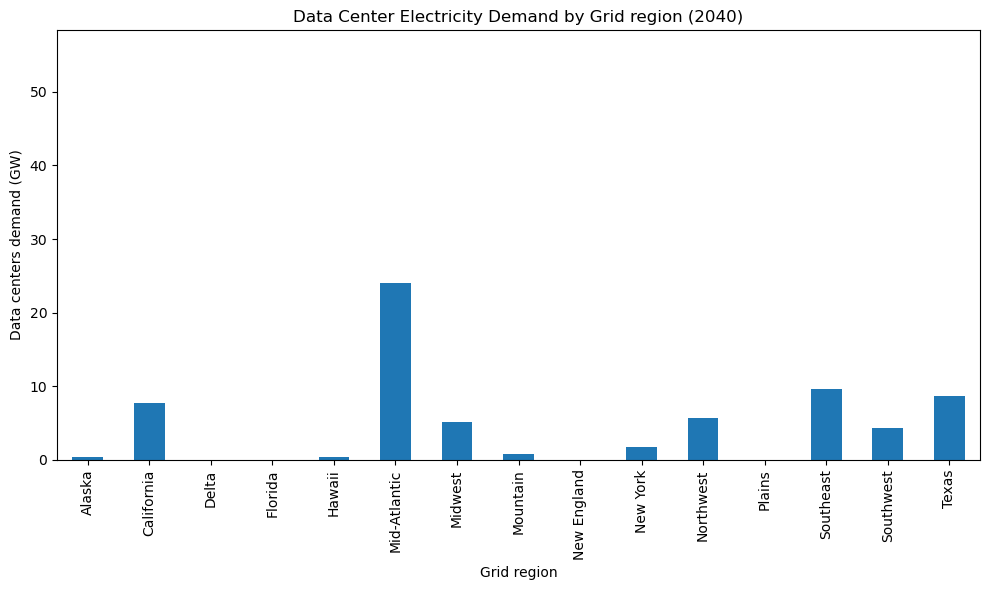

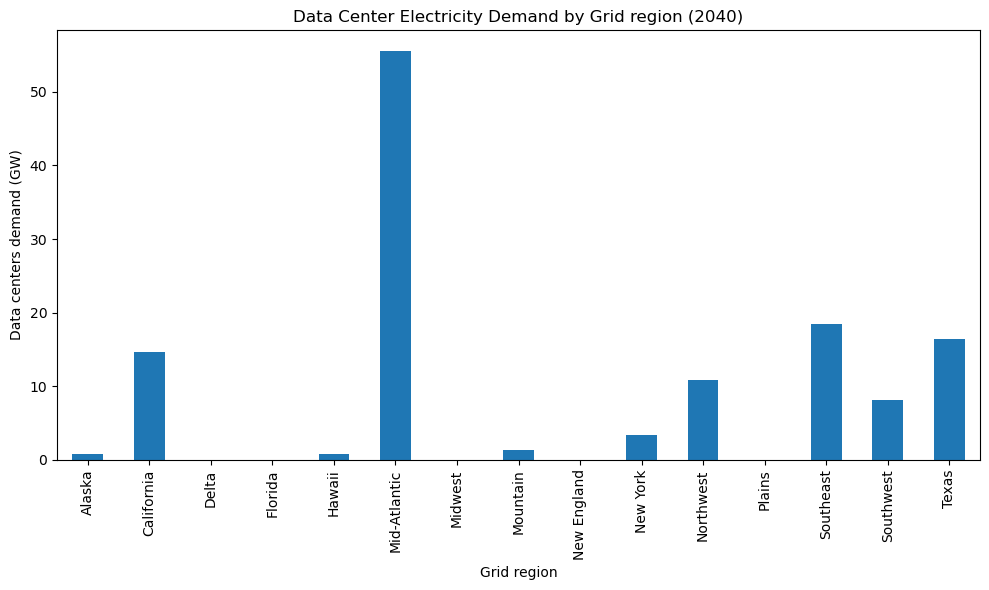

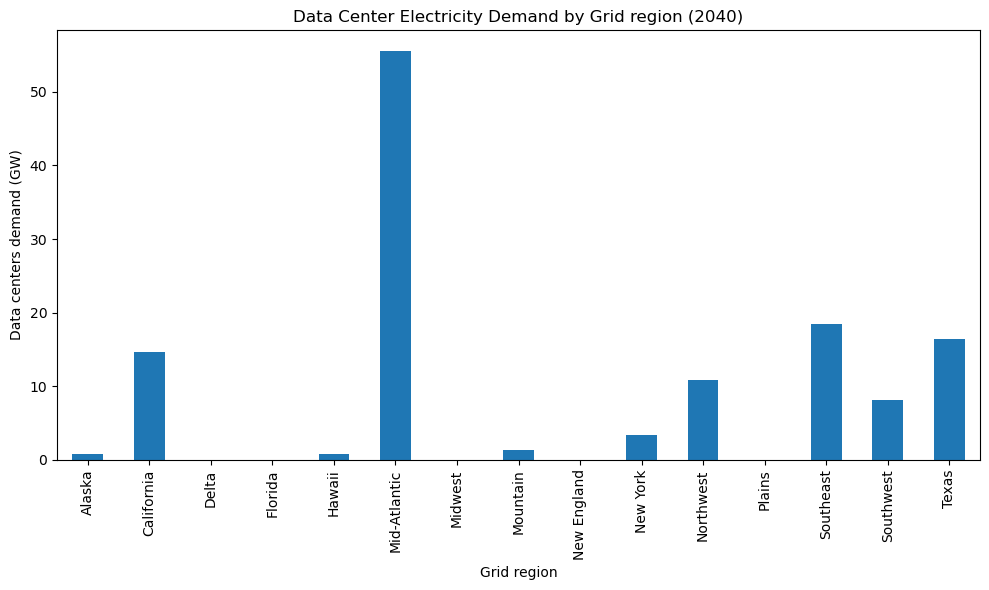

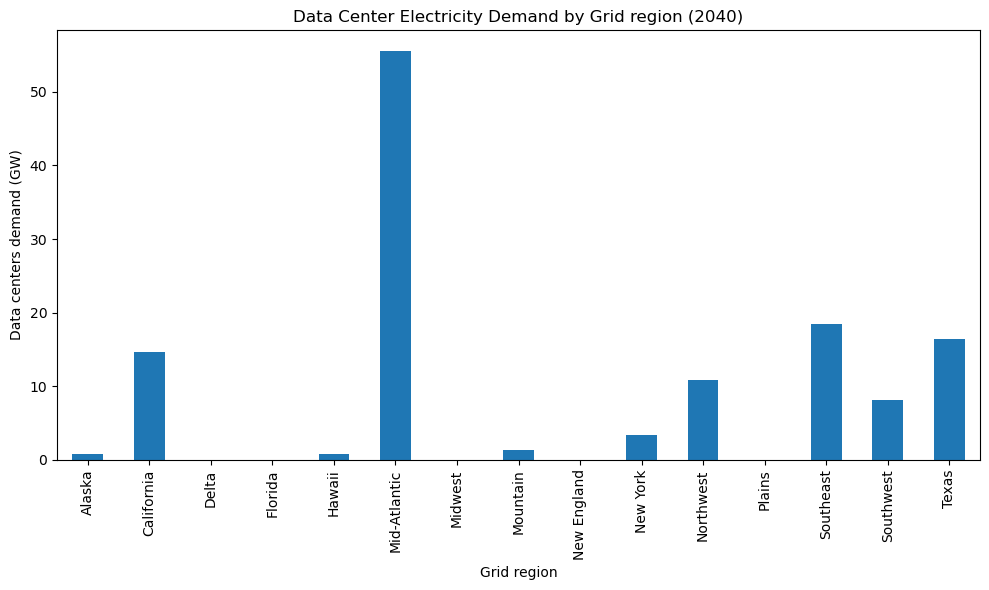

In [34]:
data_center_load = {}
for key, net in networks.items():
    data_center_load[key] = compute_data_center_load(net)

max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    max_val = max(max_val, demand_by_grid_region.max())

for key, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)

    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by Grid region ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()


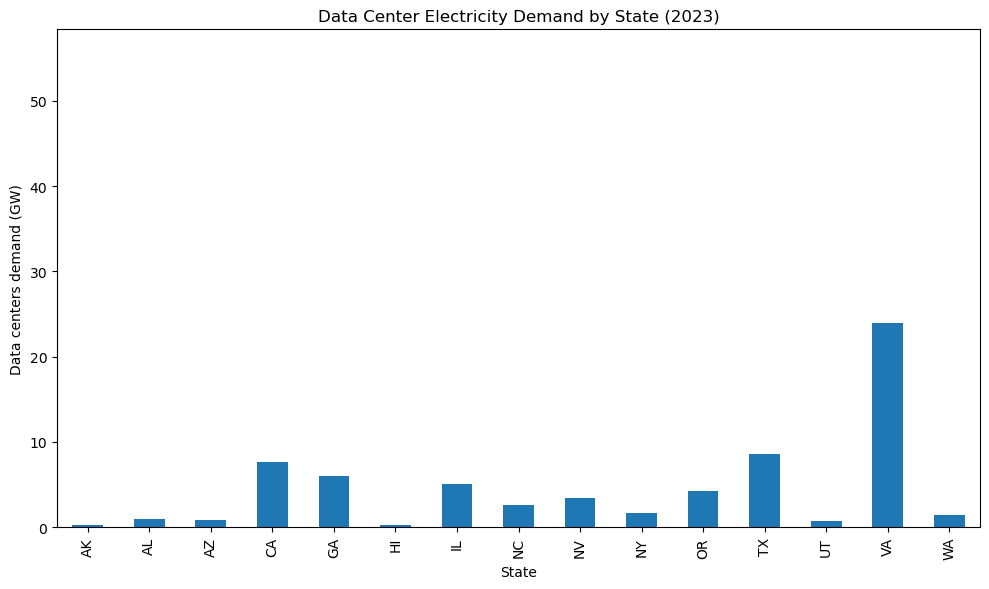

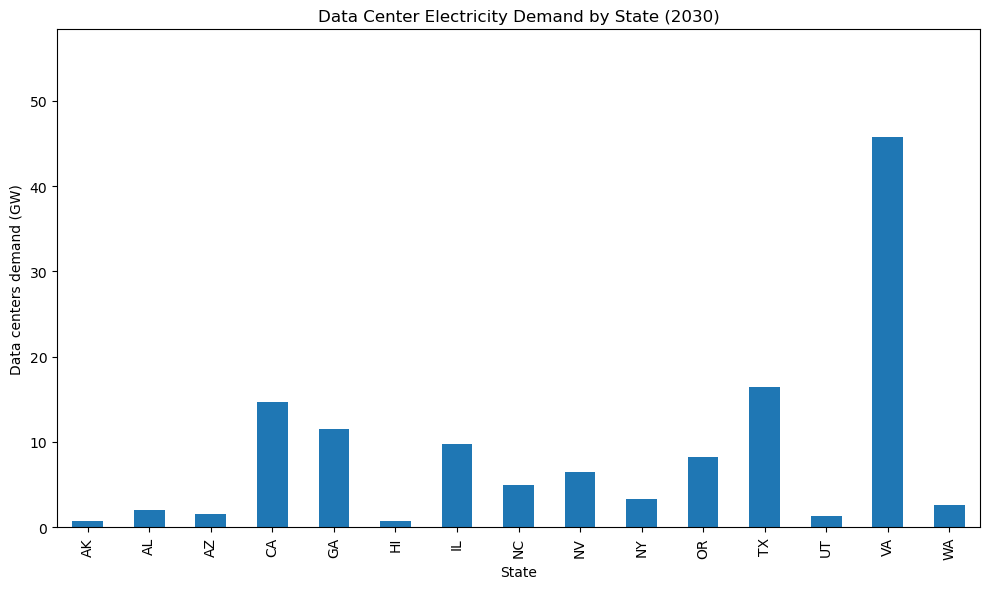

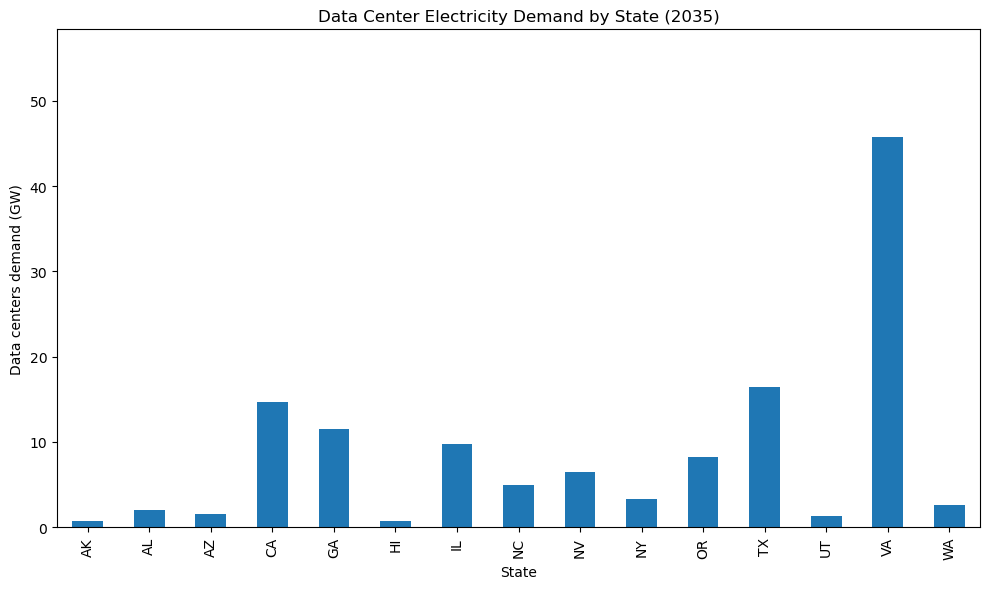

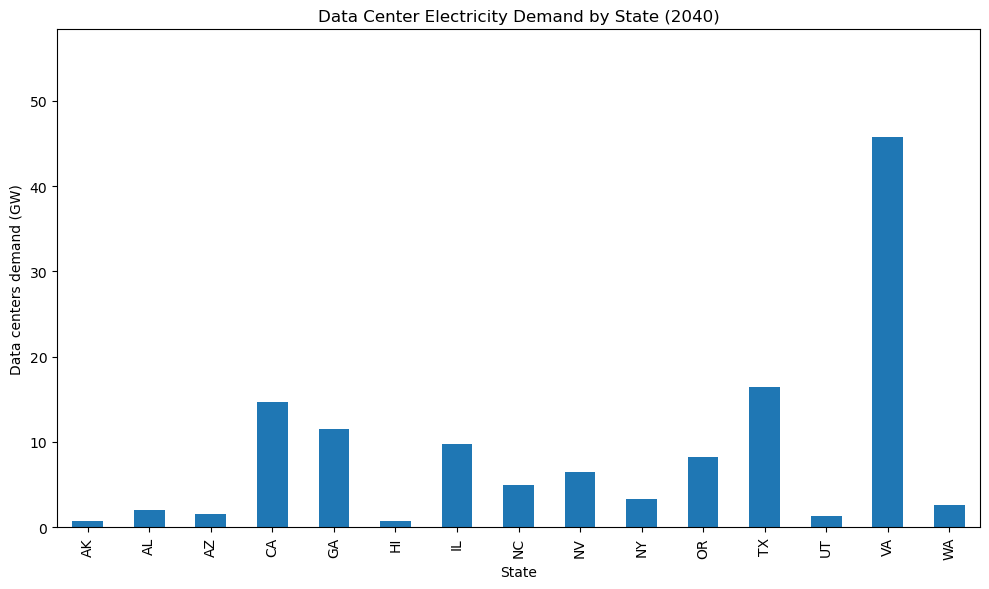

In [35]:
for key, df in data_center_load.items():
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"No demand data for {key}")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by State ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [36]:
# Code to extract objective value (total cost) from each network
# cost_data = {name: n.objective for name, n in networks.items()}
# pd.Series(cost_data).plot(kind='bar', title='Total Annual System Cost')
pass

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [88]:
def update_ac_dc_bus_coordinates(network):
    """
    For all buses with carrier 'AC' or 'DC', update their 'x' and 'y' coordinates
    based on their 'location' field and the mapping from existing AC/DC buses.
    """
    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]
    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    return network

def fill_missing_nice_names(n, nice_names):
    """
    Fill missing nice_name values in n.carriers using the provided nice_names dict.
    Prints carriers that were missing and their new nice_name.
    """
    missing = n.carriers[n.carriers.nice_name == ""].index
    for idx in missing:
        print(f"Carrier '{idx}' is missing from the network.")
        if idx in nice_names:
            n.carriers.nice_name[idx] = nice_names[idx]
            print(n.carriers.nice_name[idx])
        else:
            print(f"No nice_name found for '{idx}' in nice_names dictionary.")

regions_onshore = gpd.read_file(region_shapes_path)

# Prepare Data for Plotting
gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

line_values = n.lines.s_nom
links_values = n.links[n.links.carrier == "DC"].p_nom

n = update_ac_dc_bus_coordinates(n)

# Find carriers that need a color
carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
for carrier in carriers_to_plot:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for idx in tech_colors.keys():
    n.carriers.loc[idx, "color"] = tech_colors[idx]
    
fill_missing_nice_names(n, nice_names)

# Assign colors from the dictionary, using 'gray' for any not found
n.carriers["color"] = n.carriers.index.map(tech_colors)
n.carriers.color.fillna("gray", inplace=True)


Plotting network: Base_2023


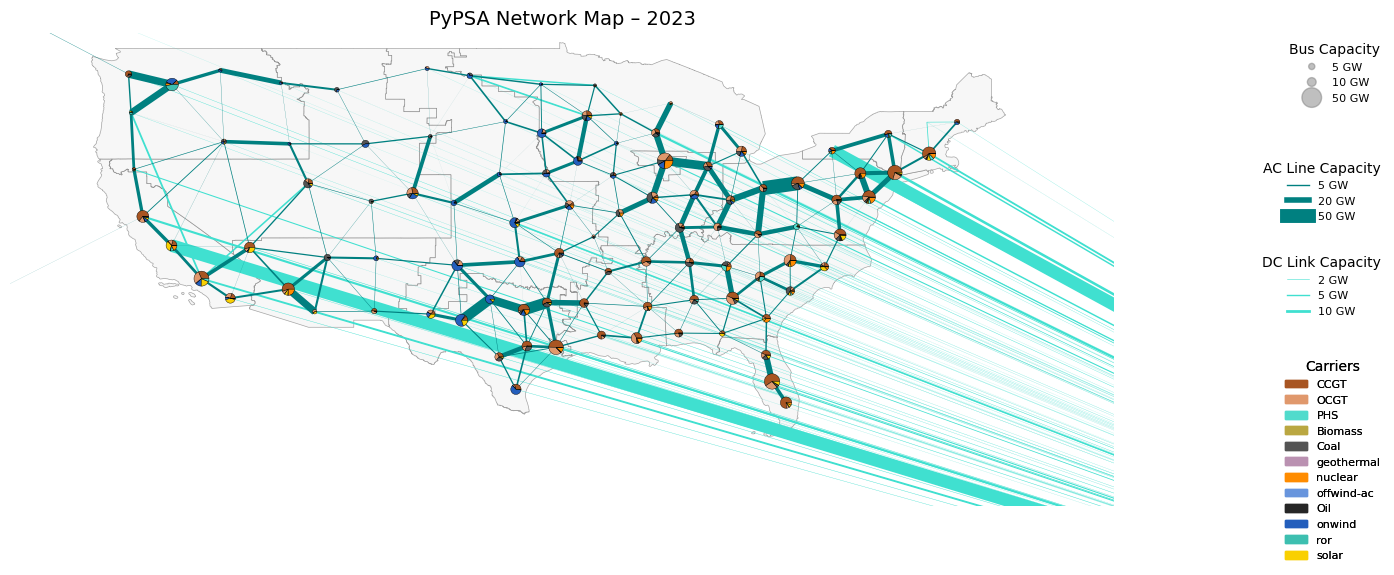

Plotting network: scenario_01_2030


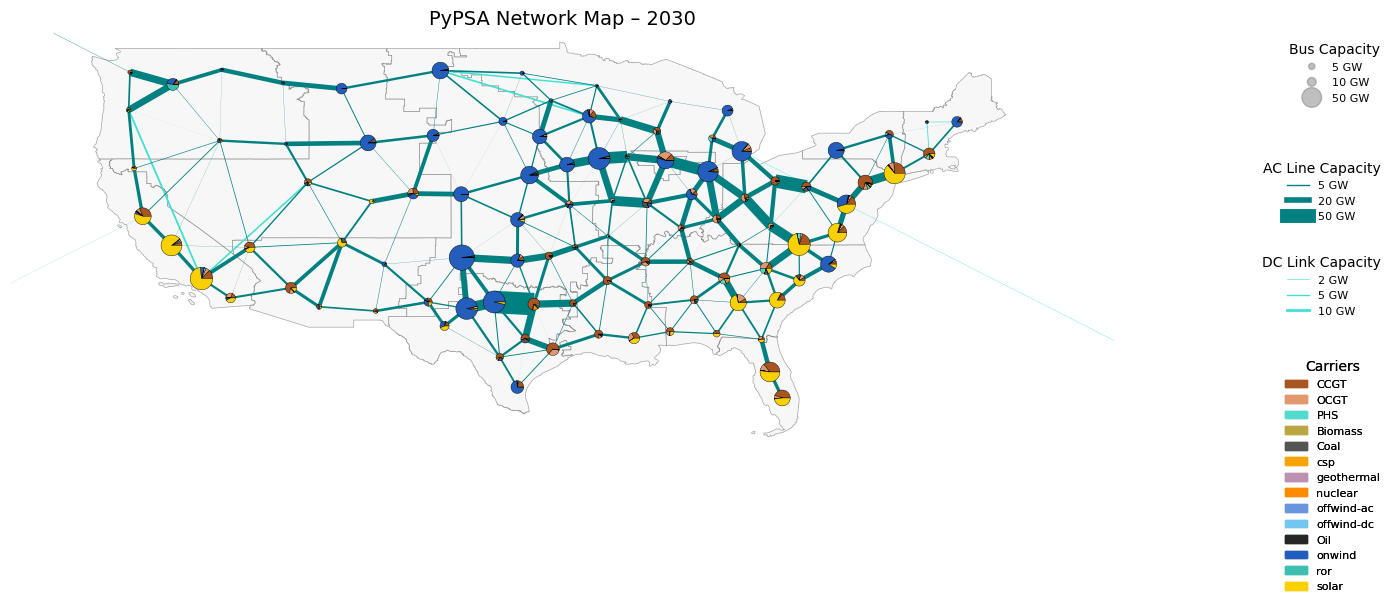

Plotting network: scenario_01_2035


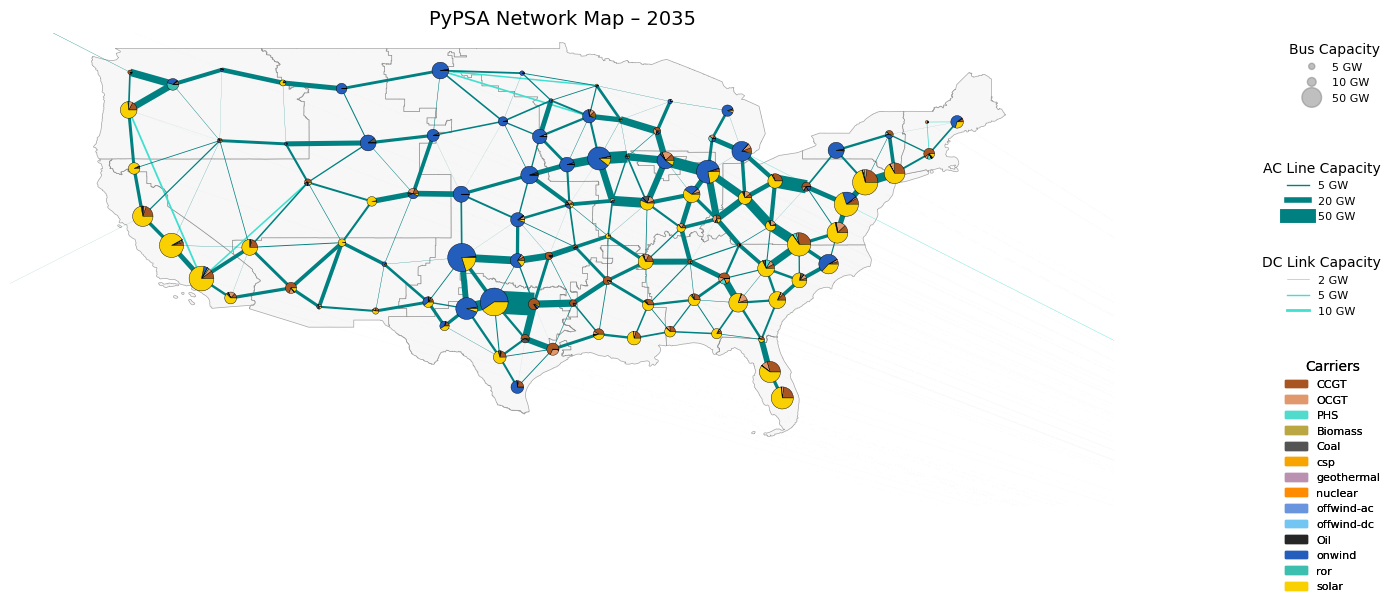

Plotting network: scenario_01_2040


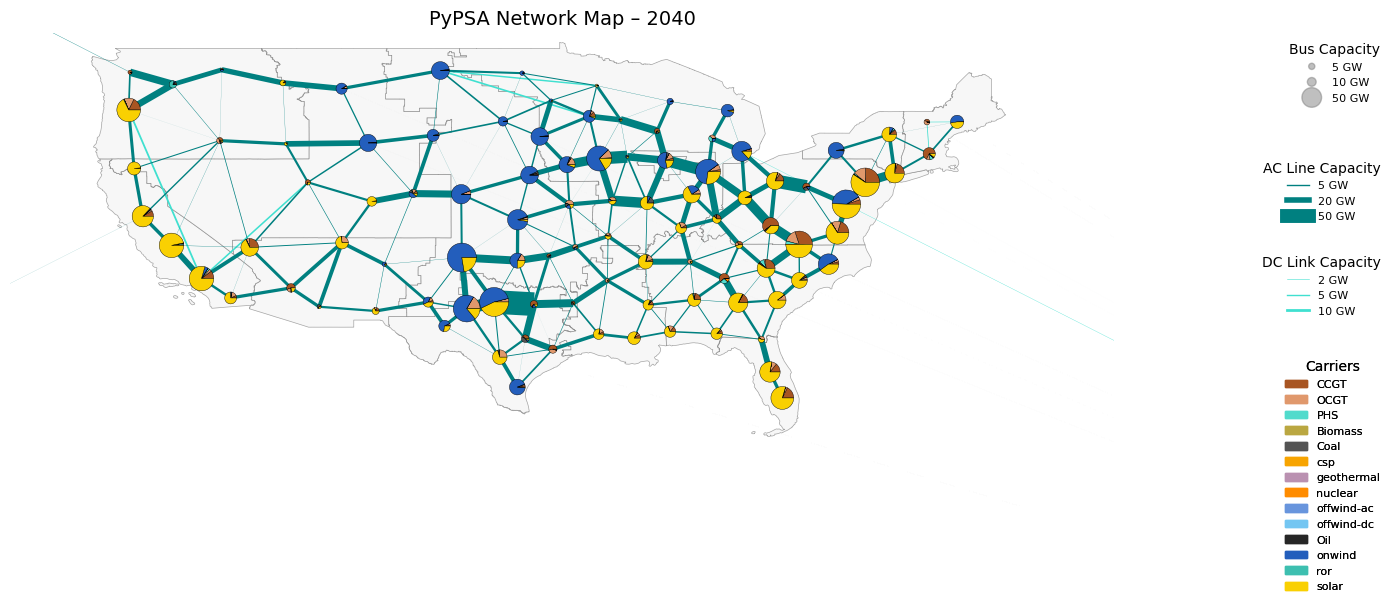

In [188]:
for key, n in networks.items():
    print(f"Plotting network: {key}")
    
    # Electricity generators (or links, using efficiency to scale them)
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }
    
    gen_p_nom_opt = n.generators[n.generators.carrier.isin(gen_carriers)]
    gen_p_nom_opt = gen_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    sto_p_nom_opt = n.storage_units[n.storage_units.carrier.isin(gen_carriers)]
    sto_p_nom_opt = sto_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    link_mask = (
        n.links.efficiency.notnull()
        & (n.links.p_nom_opt > 0)
        & n.links.carrier.isin(link_carriers)
    )
    electricity_links = n.links[link_mask].copy()
    electricity_links["electric_output"] = electricity_links.p_nom_opt * electricity_links.efficiency
    link_p_nom_opt = electricity_links.groupby(["bus1", "carrier"]).electric_output.sum()
    link_p_nom_opt.index = link_p_nom_opt.index.set_names(["bus", "carrier"])
    
    # Join all contributors to electricity generators
    bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt, link_p_nom_opt])
    bus_carrier_capacity = bus_carrier_capacity.groupby(level=[0, 1]).sum()
    bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]
    
    # Valid coordinates for buses
    valid_buses = n.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]
    
    # Capacity per bus and carrier
    capacity_df = bus_carrier_capacity.unstack(fill_value=0)
    capacity_df = capacity_df.loc[capacity_df.index.intersection(valid_buses.index)]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    
    # Setup Map
    regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )
    
    # Represent transmission capacity
    line_scale = 5e3
    n.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
    )
    
    # Pie chart for capacities
    pie_scale = 0.003
    for bus_id, capacities in capacity_df.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue
    
        values = capacities.values
        total = values.sum()
        if total == 0:
            continue
    
        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            
    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    # Legends
    bus_caps = [5, 10, 50]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)
    
    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} GW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.25, 1.0)
    )
    
    ac_caps = [5e3, 20e3, 50e3]
    ac_patches = [
        mlines.Line2D([], [], color='teal', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in ac_caps
    ]
    ac_legend = ax.legend(
        handles=ac_patches,
        title="AC Line Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.25, 0.75)
    )
    
    dc_caps = [2e3, 5e3, 10e3]
    dc_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in dc_caps
    ]
    dc_legend = ax.legend(
        handles=dc_patches,
        title="DC Link Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.25, 0.55)
    )
    
    carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(capacity_df.columns) if capacity_df[c].sum() > 0
    ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.25, 0.33),
        ncol=1
    )
    
    ax.add_artist(bus_legend)
    ax.add_artist(ac_legend)
    ax.add_artist(dc_legend)
    ax.add_artist(carrier_legend)
        
    ax.set_extent([-130, -60, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)
    
    year = key[-4:]  # Estrazione ultime 4 cifre (anno)
    ax.set_title(f"PyPSA Network Map – {year}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

In [ ]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):

        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, 'location'] = names.str[:i]

In [ ]:
h2_carriers = ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC',]


In [ ]:
def create_hydrogen_capacity_map(network, path_shapes, distance_crs=4326, min_capacity_mw=10):
    """
    Create a map with pie charts showing hydrogen electrolyzer capacity breakdown by type for each state
    """
    if hasattr(network, 'links') and len(network.links) > 0:
            # Filter for hydrogen-related links (electrolyzers)
            # Common naming patterns for electrolyzers in PyPSA
            hydrogen_links = network.links[
                network.links['carrier'].str.contains('H2|hydrogen|electroly|SOEC', case=False, na=False) |
                network.links.index.str.contains('H2|hydrogen|electroly|SOEC', case=False, na=False)
            ].copy()
    
    capacity_data = hydrogen_links.merge(
                network.buses[['state']], 
                left_on='bus0',  # Assuming bus0 is the electrical connection
                right_index=True, 
                how='left'
            )
    
    # capacity_data = links_with_state
    
    # Convert MW to MW (keep as MW for hydrogen as capacities are typically smaller)
    capacity_data['p_nom_mw'] = capacity_data['p_nom_opt']
    
    print(f"Found hydrogen capacity data for {capacity_data['state'].nunique()} states")
    print("Electrolyzer types found:", capacity_data['carrier'].unique().tolist())
    
    # Step 2: Read and prepare shapefile
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)
    
    # Get state centroids for pie chart placement
    shapes_centroid = shapes.copy()
    shapes_centroid['centroid'] = shapes_centroid.geometry.centroid
    shapes_centroid['cent_x'] = shapes_centroid.centroid.x
    shapes_centroid['cent_y'] = shapes_centroid.centroid.y
    
    # Step 3: Define colors for electrolyzer types
    unique_carriers = capacity_data['carrier'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_carriers)))
    carrier_colors = dict(zip(unique_carriers, colors))
    
    # Customize colors for common electrolyzer types
    custom_colors = {
        'H2 Electrolysis': '#1f77b4',           # Blue
        'alkaline': '#ff7f0e',                  # Orange  
        'PEM': '#2ca02c',                       # Green
        'SOEC': '#d62728',                      # Red
        'AEL': '#9467bd',                       # Purple
        'electrolyzer': '#8c564b',              # Brown
        'hydrogen': '#e377c2',                  # Pink
        'H2': '#7f7f7f',                        # Gray
    }
    
    # Update carrier_colors with custom colors
    for carrier, color in custom_colors.items():
        if carrier in carrier_colors:
            carrier_colors[carrier] = color
    
    # Step 4: Create the plot
    fig, ax = plt.subplots(figsize=(30, 20))
    
    # Plot the base map
    shapes.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)
    
    # Group capacity data by state
    state_capacity = capacity_data.groupby('state').agg({
        'p_nom_mw': 'sum'
    }).reset_index()
    
    # Filter states with minimum capacity
    states_to_plot = state_capacity['state'].tolist()
    
    print(f"Plotting {len(states_to_plot)} states with ≥{min_capacity_mw} MW hydrogen capacity")
    
    # Step 5: Create pie charts for each state
    for state in states_to_plot:
        state_data = capacity_data[capacity_data['state'] == state]
        
        if len(state_data) == 0:
            continue
            
        # Get state centroid
        state_centroid = shapes_centroid[shapes_centroid['State'] == state]
        if len(state_centroid) == 0:
            continue
            
        cent_x = state_centroid['cent_x'].iloc[0]
        cent_y = state_centroid['cent_y'].iloc[0]
        
        # Prepare pie chart data
        sizes = state_data['p_nom_mw'].values
        labels = state_data['carrier'].values
        colors_list = [carrier_colors[carrier] for carrier in labels]
        
        # Calculate pie chart radius based on total capacity
        total_capacity = sizes.sum()
        # Scale radius based on capacity (adjusted for MW scale)
        max_capacity = state_capacity['p_nom_mw'].max()
        radius = 0.3 + (total_capacity / max_capacity) * 1.5
        
        # Create pie chart
        pie_wedges, texts = ax.pie(sizes, colors=colors_list, center=(cent_x, cent_y), 
                                  radius=radius, startangle=90)
        
        # Add capacity label
        ax.annotate(f'{total_capacity:.0f} MW', 
                   xy=(cent_x, cent_y - radius - 0.3), 
                   ha='center', va='top', fontsize=12, fontweight='bold')
    
    # Step 6: Create legend
    legend_elements = []
    for carrier, color in carrier_colors.items():
        if carrier in capacity_data['carrier'].values:
            # Clean up carrier names for legend
            display_name = carrier.replace('_', ' ').title()
            legend_elements.append(mpatches.Patch(color=color, label=display_name))
    
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
             fontsize=14, title='Electrolyzer Type', title_fontsize=16)
    
    # Step 7: Formatting - Expand map boundaries
    x_buffer = (shapes.total_bounds[2] - shapes.total_bounds[0]) * 0.1
    y_buffer = (shapes.total_bounds[3] - shapes.total_bounds[1]) * 0.1
    
    ax.set_xlim([-130, -65])
    ax.set_ylim([20,55])
    ax.set_aspect('equal')
    ax.axis('off')
    
    ax.set_title('Installed Hydrogen Electrolyzer Capacity by State and Type', 
                fontsize=24, fontweight='bold', pad=30)
    
    # Add subtitle
    ax.text(0.5, 0.02, f'Note: Only states with ≥{min_capacity_mw} MW electrolyzer capacity are shown', 
           transform=ax.transAxes, ha='center', fontsize=14, style='italic')
    
    plt.tight_layout()
    return fig, ax, capacity_data

def print_hydrogen_capacity_summary(capacity_data):
    """Print summary statistics of the hydrogen capacity data"""
    if len(capacity_data) == 0:
        print("No hydrogen capacity data to summarize.")
        return
        
    print("=== HYDROGEN ELECTROLYZER CAPACITY SUMMARY ===")
    print(f"Total installed hydrogen capacity: {capacity_data['p_nom'].sum():.1f} MW")
    print(f"Number of states with hydrogen capacity: {capacity_data['state'].nunique()}")
    print(f"Number of electrolyzer types: {capacity_data['carrier'].nunique()}")
    
    print("\n=== TOP 10 STATES BY HYDROGEN CAPACITY ===")
    state_totals = capacity_data.groupby('state')['p_nom'].sum().sort_values(ascending=False)
    for i, (state, capacity) in enumerate(state_totals.head(10).items()):
        print(f"{i+1:2d}. {state}: {capacity:.1f} MW")
    
    print("\n=== ELECTROLYZER TYPE MIX (NATIONAL) ===")
    carrier_totals = capacity_data.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
    total_national = carrier_totals.sum()
    for carrier, capacity in carrier_totals.items():
        print(f"{carrier:25s}: {capacity:8.1f} MW ({capacity/total_national*100:5.1f}%)")


In [ ]:
n = networks["Base Scenario"].copy()

In [ ]:
fig, ax, capacity_data = create_hydrogen_capacity_map(
    n, 
    state_shapes_path, 
    min_capacity_mw=10  # Only show states with at least 50 MW
)

In [ ]:
print_hydrogen_capacity_summary(capacity_data)

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-fuel production.*

In [ ]:
networks.keys()

In [ ]:
n = networks["Scenario A"].copy()

In [ ]:
ft_links = n.links[
        n.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        n.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()

In [ ]:
ft_links.p_nom_opt

In [ ]:
def create_ft_capacity_map(network, path_shapes, distance_crs=4326, min_capacity_mw=10):
    """
    Create a map with pie charts showing FT (Fischer-Tropsch) capacity breakdown by type for each state
    """
    # Filter for FT-related links (Fischer-Tropsch synthesis units)
    ft_links = network.links[
        network.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        network.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()
    
    if ft_links.empty:
        print("No FT links found in the network.")
        return None, None, None

    # Attach state info
    links_with_state = ft_links.merge(
        network.buses[['state']],
        left_on='bus0',
        right_index=True,
        how='left'
    )
    links_with_state['p_nom_mw'] = links_with_state['p_nom_opt']

    # Read and prepare shapefile
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)
    shapes_centroid = shapes.copy()
    shapes_centroid['centroid'] = shapes_centroid.geometry.centroid
    shapes_centroid['cent_x'] = shapes_centroid.centroid.x
    shapes_centroid['cent_y'] = shapes_centroid.centroid.y

    # Colors for FT types
    unique_carriers = links_with_state['carrier'].unique()
    colors = plt.cm.Paired(np.linspace(0, 1, len(unique_carriers)))
    carrier_colors = dict(zip(unique_carriers, colors))
    custom_colors = {
        'FT': '#8B0000',
        'fischer-tropsch': '#B22222',
        'fischer_tropsch': '#B22222',
        'Fischer-Tropsch': '#B22222',
    }
    for carrier, color in custom_colors.items():
        for uc in unique_carriers:
            if carrier.lower() in uc.lower():
                carrier_colors[uc] = color

    # Group capacity data by state
    state_capacity = links_with_state.groupby('state').agg({'p_nom_opt': 'sum'}).reset_index()
    states_to_plot = state_capacity[state_capacity['p_nom_opt'] >= min_capacity_mw]['state'].tolist()

    fig, ax = plt.subplots(figsize=(20, 15))
    shapes.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)

    for state in states_to_plot:
        state_data = links_with_state[links_with_state['state'] == state]
        if len(state_data) == 0:
            continue
        state_centroid = shapes_centroid[shapes_centroid['State'] == state]
        if len(state_centroid) == 0:
            continue
        cent_x = state_centroid['cent_x'].iloc[0]
        cent_y = state_centroid['cent_y'].iloc[0]
        sizes = state_data['p_nom_opt'].values
        labels = state_data['carrier'].values
        colors_list = [carrier_colors[carrier] for carrier in labels]
        total_capacity = sizes.sum()
        max_capacity = state_capacity['p_nom_opt'].max()
        radius = 0.3 + (total_capacity / max_capacity) * 1.5
        pie_wedges, texts = ax.pie(sizes, colors=colors_list, center=(cent_x, cent_y),
                                   radius=radius, startangle=90)
        ax.annotate(f'{total_capacity:.5f} MW',
                    xy=(cent_x, cent_y - radius - 0.3),
                    ha='center', va='top', fontsize=12, fontweight='bold')

    # Legend
    legend_elements = []
    for carrier, color in carrier_colors.items():
        if carrier in links_with_state['carrier'].values:
            display_name = carrier.replace('_', ' ').title()
            legend_elements.append(mpatches.Patch(color=color, label=display_name))
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
              fontsize=14, title='FT Type', title_fontsize=16)

    ax.set_xlim([-130, -65])
    ax.set_ylim([20, 55])
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Installed Fischer-Tropsch Capacity by State and Type',
                 fontsize=20, fontweight='bold', pad=30)
    ax.text(0.5, 0.02, f'Note: Only states with ≥{min_capacity_mw} MW FT capacity are shown',
            transform=ax.transAxes, ha='center', fontsize=12, style='italic')
    plt.tight_layout()
    return fig, ax, links_with_state



In [ ]:
fig, ax, ft_capacity_data = create_ft_capacity_map(
    n,
    state_shapes_path,
    min_capacity_mw=0.0001
)

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [ ]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

In [ ]:
carrier_colors = {
    # Electricity
    'solar': '#f9d002',
    'wind': '#235ebc',
    'onwind': '#235ebc',
    'offwind': '#6ca5e8',
    'hydro': '#08ad97',
    'ror': '#4adbc8',
    'gas': '#d35050',
    'OCGT': '#d35050',
    'CCGT': '#b00b0b',
    'biomass': '#067a16',
    'geothermal': '#8d50f3',
    'nuclear': '#d482d8',
    # Hydrogen
    'H2 Electrolysis': '#ff00ff',
    'PEM Electrolysis': '#ff00ff',
    'Alkaline Electrolysis': '#f080f0',
    'H2 Fuel Cell': '#ff77ff',
    # Synfuels
    'Fischer-Tropsch': '#5b5b5b',
    'methanolisation': '#c4a68a',
}

In [ ]:
# Add colors for the 'other' category and storage
carrier_colors['other'] = 'darkgray'
carrier_colors['H2 Store Discharge'] = '#f080f0' # A lighter magenta for H2 storage
carrier_colors['H2 Store Charge'] = '#f080f0'

def filter_and_group_small_carriers(df, threshold=0.005):
    """
    Filters a DataFrame to group small contributors into an 'other' category.
    This function assumes df contains only non-negative values.
    """
    if df.empty or df.sum().sum() == 0:
        return pd.DataFrame(index=df.index)
    totals = df.sum()
    grand_total = totals.sum()
    significant_carriers = totals[totals / grand_total > threshold].index
    df_filtered = df[significant_carriers].copy()
    other_carriers = totals[~totals.index.isin(significant_carriers)].index
    if not other_carriers.empty:
        df_filtered['other'] = df[other_carriers].sum(axis=1)
    return df_filtered


def plot_dispatch(n, start_date=None, end_date=None):
    """
    Plots the electricity and hydrogen dispatch, grouping small contributors
    and correctly handling multiple storage units.

    (Version 8: Aggregates multi-column storage flow.)
    """
    if start_date and end_date:
        snapshots_slice = slice(start_date, end_date)
        title_suffix = f"from {start_date} to {end_date}"
    else:
        snapshots_slice = slice(None)
        title_suffix = f"for the full period ({n.snapshots[0].year})"

    sliced_snapshots_index = n.snapshots[snapshots_slice]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)
    plt.style.use('ggplot')
    
    # ... (Electricity plot remains the same, it is robust) ...
    ax1.set_title(f"Electricity Dispatch {title_suffix}", fontsize=16)
    gen_dispatch = n.generators_t.p.loc[snapshots_slice].groupby(n.generators.carrier, axis=1).sum()
    storage_dispatch = n.storage_units_t.p.loc[snapshots_slice].groupby(n.storage_units.carrier, axis=1).sum()
    elec_stores = n.stores[n.stores.bus.isin(n.buses[n.buses.carrier == 'AC'].index)]
    store_dispatch = pd.DataFrame(index=sliced_snapshots_index)
    if not elec_stores.empty:
        store_dispatch = -n.stores_t.p.loc[snapshots_slice, elec_stores.index].groupby(elec_stores.carrier, axis=1).sum()
    supply = pd.concat([gen_dispatch, storage_dispatch, store_dispatch], axis=1)
    supply_positive = supply.clip(lower=0) # Use clip for a robust way to get non-negative
    supply_filtered = filter_and_group_small_carriers(supply_positive, threshold=0.005)
    demand = n.loads_t.p_set.loc[snapshots_slice].groupby(n.loads.carrier, axis=1).sum()
    supply_filtered.plot(kind='area', ax=ax1, stacked=True, linewidth=0, color=[carrier_colors.get(c, 'gray') for c in supply_filtered.columns])
    # demand.plot(kind='area', ax=ax1, linewidth=0, stacked=True)
    ax1.set_ylabel("Power (MW)")
    ax1.set_xlabel('Time')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    ax1.set_ylim(bottom=0)

    h2_carriers = n.links.carrier.filter(like="H2").unique()
    h2_links = n.links.query("carrier in @h2_carriers")
    h2_dispatch = n.links_t.p1[h2_links.index].groupby(n.links.loc[h2_links.index, 'carrier'], axis=1).sum()
    
    h2_dispatch.plot(ax=ax2, alpha=0.7)
    ax2.set_title('Hydrogen Dispatch Throughout the Year')
    ax2.set_ylabel('Power [MW]')
    ax2.set_xlabel('Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


In [ ]:
plot_dispatch(n)

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE at different buses. This shows the all-in cost of producing electricity at various points in the network.*

In [ ]:
shapes = gpd.read_file(region_shapes_path)

In [ ]:
n = attach_grid_region_to_buses(n, region_shapes_path)
n = attach_state_to_buses(n, state_shapes_path)

In [ ]:
# Assume: generator has attributes capital_cost, marginal_cost, p_nom_opt, and p (power output time-series)

gen = n.generators
dispatch = n.generators_t.p  # hourly power generation

# Total energy generated (MWh)
energy = dispatch.sum(axis=0) * n.snapshot_weightings.generators.sum() / 1e3  # convert to GWh or MWh if needed

# LCOE = (Annualized Capital + Operating) / Energy
lcoe = (gen.capital_cost * gen.p_nom_opt + gen.marginal_cost * energy) / energy
lcoe = lcoe.replace(np.inf, np.nan).dropna()

gen['lcoe'] = lcoe
lcoe_data = gen[['bus', 'lcoe', 'carrier']]
lcoe_data = lcoe_data.merge(n.buses[['x', 'y']], left_on='bus', right_index=True)
lcoe_data["clean_bus"] = lcoe_data.bus.str.extract(r"(US\d{1} \d{1,2})")
lcoe_data['region'] = lcoe_data.clean_bus.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoe_data['x'], lcoe_data['y'])]
lcoe_gdf = gpd.GeoDataFrame(lcoe_data, geometry=geometry, crs=shapes.crs)
lcoe_gdf = lcoe_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoe_gdf.plot(
    ax=ax,
    column='lcoe',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOE by Location")
plt.axis('off')
plt.show()

In [ ]:
lcoe_data.groupby(['region', 'carrier'])['lcoe'].sum().unstack()

In [ ]:
lcoe_data.groupby("region")["lcoe"].sum().plot(kind='bar')
plt.show()

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH at buses where hydrogen is produced. This is a critical metric for the hydrogen economy.*

In [ ]:
h2_carriers = ["Alkaline electrolyzer large", "Alkaline electrolyzer medium",
            "Alkaline electrolyzer small", "PEM electrolyzer", "SOEC"]

hydrogen_links = n.links.query("carrier in @h2_carriers")
hydrogen_dispatch = n.links_t.p0[hydrogen_links.index]  # p0 is power input to electrolyzers

# Total H2 energy output: p1 is H2 output
h2_output = -n.links_t.p1[hydrogen_links.index].sum(axis=0)

lcoh = (hydrogen_links.capital_cost * hydrogen_links.p_nom_opt + hydrogen_links.marginal_cost * h2_output) / h2_output

hydrogen_links['lcoh'] = lcoh
lcoh_data = hydrogen_links[['bus0', 'lcoh', 'carrier']]
lcoh_data = lcoh_data.merge(n.buses[['x', 'y']], left_on='bus0', right_index=True)
lcoh_data['region'] = lcoh_data.bus0.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoh_data['x'], lcoh_data['y'])]
lcoh_gdf = gpd.GeoDataFrame(lcoh_data, geometry=geometry, crs=shapes.crs)
lcoh_gdf = lcoh_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoh_gdf.plot(
    ax=ax,
    column='lcoh',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOH by Location")
plt.axis('off')
plt.show()

In [ ]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack()

In [ ]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack().plot(
    kind='bar',
    width=0.8
)
ax.set_ylabel('LCOH')
ax.set_xlabel('Region')
ax.set_title('Levelized Cost of Hydrogen (LCOH) by Region and Electrolyzer Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## 7. Sector-Specific Analysis: E-Kerosene Deep Dive

*A dedicated section to analyze the production chain, costs, and outputs related to synthetic aviation fuel.*

### 7.1. E-Kerosene Production and Costs
*Analysis of the Fischer-Tropsch process, including inputs (H2, CO2), outputs (e-kerosene), and the resulting levelized cost of the fuel.*

In [ ]:
# Code to analyze the FT links, their inputs/outputs,
# and calculate the Levelized Cost of Kerosene (LCOK).
pass

---